### Step 1. Open the data file

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math

try:
    df = pd.read_csv('../datasets/real_estate_data_us.csv')
except:
    df = pd.read_csv('/datasets/real_estate_data_us.csv','\t')

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_posted        23699 non-null  object 
 1   days_listed        20518 non-null  float64
 2   last_price         23699 non-null  float64
 3   bedrooms           23699 non-null  int64  
 4   kitchen_area       21421 non-null  float64
 5   living_area        21796 non-null  float64
 6   total_area         23699 non-null  float64
 7   balconies          12180 non-null  float64
 8   ceiling_height     14504 non-null  float64
 9   floors_total       23613 non-null  float64
 10  floor              23699 non-null  int64  
 11  total_images       23699 non-null  int64  
 12  bike_parking       2775 non-null   object 
 13  is_studio          23699 non-null  bool   
 14  is_open_plan       23699 non-null  bool   
 15  locality_name      23650 non-null  object 
 16  airport_dist       181

None

In [3]:
display(df.sample(5))

,date_posted,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,...,bike_parking,is_studio,is_open_plan,locality_name,airport_dist,city_center_dist,park_dist,parks_within_3000,pond_dist,ponds_within_3000
10821,2019-02-12T00:00:00,NaN,83800.0,3,5.3,29.9,41.9,NaN,2.65,5.0,...,NaN,False,False,Saint Petersburg,12708.0,13949.0,NaN,0.0,91.0,1.0
15140,2018-01-15T00:00:00,51.0,22000.0,1,10.0,24.0,34.0,NaN,2.50,2.0,...,NaN,False,False,Luga,NaN,NaN,NaN,NaN,NaN,NaN
22687,2018-06-04T00:00:00,NaN,130000.0,2,18.0,40.0,74.8,NaN,3.15,7.0,...,NaN,False,False,Saint Petersburg,27653.0,5581.0,612.0,1.0,NaN,0.0
9458,2017-09-06T00:00:00,208.0,75000.0,3,7.1,35.0,50.0,1.0,2.50,5.0,...,NaN,False,False,Saint Petersburg,42190.0,11012.0,540.0,1.0,NaN,0.0
7502,2016-06-16T00:00:00,70.0,76000.0,1,9.0,16.0,37.0,0.0,NaN,12.0,...,NaN,False,False,Kudrovo village,NaN,NaN,NaN,NaN,NaN,NaN


23699 entries and 22 columns of apartment listing data

### Step 2. Data preprocessing

In [4]:
df.isna().sum()

date_posted              0
days_listed           3181
last_price               0
bedrooms                 0
kitchen_area          2278
living_area           1903
total_area               0
balconies            11519
ceiling_height        9195
floors_total            86
floor                    0
total_images             0
bike_parking         20924
is_studio                0
is_open_plan             0
locality_name           49
airport_dist          5542
city_center_dist      5519
park_dist            15620
parks_within_3000     5518
pond_dist            14589
ponds_within_3000     5518
dtype: int64

Due to not being significant to analysis:

- `bike_parking` nulls we will set to `False`
- `parks_within_3000`, `balconies` and `ponds_within_3000` can be filled with 0
- `ceiling_height`, `airport_dist`, `park_dist` and `pond_dist` can be replaced with median values


In [5]:
total_entries = len(df)
df['bike_parking'].fillna(False,inplace=True)

replace_zero = ["balconies","parks_within_3000","ponds_within_3000"]
for column in replace_zero:
    df[column].fillna(0,inplace=True)
    
replace_medians = ["ceiling_height","airport_dist","park_dist","pond_dist"]
for column in replace_medians:
    median = df[column].dropna().median()
    df[column].fillna(median,inplace=True)

- missing values in `days_listed` and `city_center_dist` will be left `NaN` to avoid shifting distribution of data
- set missing values in `kitchen_area` to 0 when `total_area` already allocated entirely to `living_area`
- use median area to total area median ratio to approximate `kitchen_area`.
- use ratio of median `floor` to median `floor_total` to approximate missing values in `floor_total`
- missing values in `locality_name` are small enough to simply drop.

In [6]:
# Calculate ratio of median kitchen area to median total area
median_kitchen_ratio = df['kitchen_area'].median() / df['total_area'].median()
def fill_kitchen_na(row):
    # Case of studio apartment/living area:total area = 1:1
    if row['living_area']==row['total_area']:
        return 0
    elif math.isnan(row['kitchen_area']):
        # if living_area is NaN then use median ratio to calculate
        if math.isnan(row['living_area']):
            return row['total_area']*median_kitchen_ratio
        # otherwise living_area is a number and calculate difference from total for kitchen_area
        else:
            return row['total_area']-row['living_area']    
    else:
        return row['kitchen_area']
df['kitchen_area'] = df.apply(fill_kitchen_na,axis=1)

# use remaining portion of total_area for living_area
def fill_living_na(row):
    return row['total_area']-row['kitchen_area']
df['living_area'] = df.apply(fill_living_na,axis=1)

floor_to_floors_total =  df['floor'].median() / df['floors_total'].median()
def fill_floors_na(row):
    if math.isnan(row['floors_total']):
        return row['floor']*floor_to_floors_total
    else:
        return row['floors_total']
df['floors_total'] = df.apply(fill_floors_na,axis=1).round()

# set locality names to lowercase for consistency
df['locality_name'] = df['locality_name'].str.lower()

df.drop_duplicates(inplace=True)
df.isnull().sum()

date_posted             0
days_listed          3181
last_price              0
bedrooms                0
kitchen_area            0
living_area             0
total_area              0
balconies               0
ceiling_height          0
floors_total            0
floor                   0
total_images            0
bike_parking            0
is_studio               0
is_open_plan            0
locality_name          49
airport_dist            0
city_center_dist     5519
park_dist               0
parks_within_3000       0
pond_dist               0
ponds_within_3000       0
dtype: int64

#### Data Type Conversion

- `date_posted` needs to be a DateTime
- `days_listed`, `last_price`, `balconies`, `floor`,`floors_total`, `airport_dist`,`city_center_dist`,`park_dist`,`ponds`,`parks_within_3000` should be ints
- `bike_parking` should be a bool

In [7]:
try:
    df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%dT%H:%M:%S')
    df['days_listed'] = df['days_listed'].astype(int,errors='ignore')
    df['last_price'] = df['last_price'].astype(int)
    df['balconies'] = df['balconies'].astype(int)
    df['floor'] = df['floor'].astype(int)
    df['floors_total'] = df['floors_total'].astype(int)
    df['airport_dist'] = df['airport_dist'].astype(int)
    df['city_center_dist'] = df['city_center_dist'].astype(int,errors='ignore')
    df['park_dist'] = df['park_dist'].astype(int)
    df['pond_dist'] = df['pond_dist'].astype(int)
    df['ponds_within_3000'] = df['ponds_within_3000'].astype(int)
    df['parks_within_3000'] = df['parks_within_3000'].astype(int)
    df['bike_parking'] = df['bike_parking'].astype(bool)
    print(df.isnull().sum())
except:
    print('Error converting type')

date_posted             0
days_listed          3181
last_price              0
bedrooms                0
kitchen_area            0
living_area             0
total_area              0
balconies               0
ceiling_height          0
floors_total            0
floor                   0
total_images            0
bike_parking            0
is_studio               0
is_open_plan            0
locality_name          49
airport_dist            0
city_center_dist     5519
park_dist               0
parks_within_3000       0
pond_dist               0
ponds_within_3000       0
dtype: int64


### Step 3. Add calculations for analysis

In [8]:
df['price_per_square_meter'] = df['last_price'] / df['total_area']
df['published_day'] = df['date_posted'].dt.dayofweek
df['published_month'] = df['date_posted'].dt.month
df['published_year'] = df['date_posted'].dt.year

def which_floor(row):
    if (row['floor'] == 1):
        return 'first'
    if (row['floor'] == row['floors_total']):
        return 'last'
    return 'other'
df['str_floor'] = df.apply(which_floor,axis=1)

df['ratio_living'] = df['living_area'] / df['total_area']
df['ratio_kitchen'] = df['kitchen_area'] / df['total_area']
df[['price_per_square_meter','str_floor','ratio_living','ratio_kitchen']].sample(5)

,price_per_square_meter,str_floor,ratio_living,ratio_kitchen
5661,1282.051282,other,0.806938,0.193062
17888,1734.693878,other,0.897959,0.102041
562,1200.000000,first,0.840000,0.160000
8540,827.586207,first,0.862069,0.137931
3225,1812.206573,other,0.859155,0.140845


### Step 4. Exploratory data analysis

For square area, price, number of rooms, and ceiling height I'll describe the data then produce a histogram to display the data using the range of first quartile to third quartile.

There are 474 outlier apartment with an area greater than 197.2140000000003 or less than 25.198999999999998


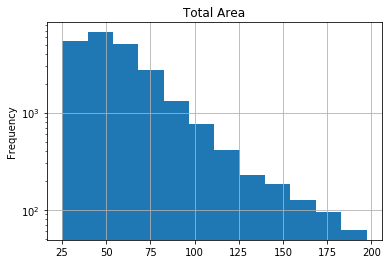

In [76]:
q1 = df['total_area'].quantile(q=0.01)
q2 = df['total_area'].quantile(q=0.99)
df['total_area'].plot(kind='hist',bins=12,range=(q1,q2),title="Total Area",grid=True,log=True)
print("There are {:} outlier apartment with an area greater than {:} or less than {:}".format(len(df.query('total_area >= @q2 or total_area <= @q1 ')),q2,q1))

There are 485 outlier apartments with a price greater than 720000.0 or less than 20000.0


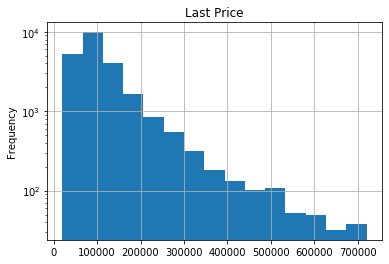

In [77]:
q1 = df['last_price'].quantile(q=0.01)
q2 = df['last_price'].quantile(q=0.99)
df['last_price'].plot(kind='hist',bins=15,range=(q1,q2),title="Last Price",grid=True,log=True)
print("There are {:} outlier apartments with a price greater than {:} or less than {:}".format(len(df.query('last_price >= @q2 or last_price <= @q1 ')),q2,q1))

There are 8765 outlier apartments with more than 5.0 or less than 1.0 bedrooms


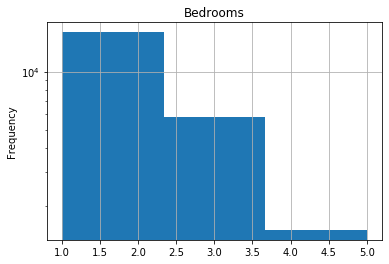

In [78]:
q1 = df['bedrooms'].quantile(q=0.01)
q2 = df['bedrooms'].quantile(q=0.99)
df['bedrooms'].plot(kind='hist',bins=3,range=(q1,q2),title="Bedrooms",grid=True,log=True)
print("There are {:} outlier apartments with more than {:} or less than {:} bedrooms".format(len(df.query('bedrooms >= @q2 or bedrooms <= @q1 ')),q2,q1))

There are 3850 outlier apartments with ceiling height greater than 3.6 or less than 2.5


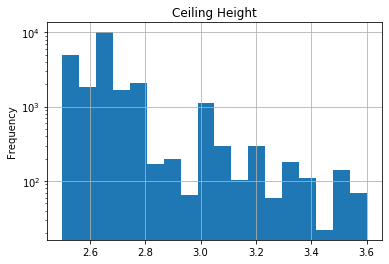

In [79]:
q1 = df['ceiling_height'].quantile(q=0.01)
q2 = df['ceiling_height'].quantile(q=0.99)
df['ceiling_height'].plot(kind='hist',bins=18,title="Ceiling Height",range=(q1,q2),grid=True,log=True)
print(
    "There are {:} outlier apartments with ceiling height greater than {:} or less than {:}"
    .format(len(df.query('ceiling_height >= @q2 or ceiling_height <= @q1 ')),q2,q1)
)
# outlier ceiling above 80

The average time to sell an apartment is 95.0 days
There are 544 outlier apartments with days listed great than 1068.6599999999962 or less than 4.0


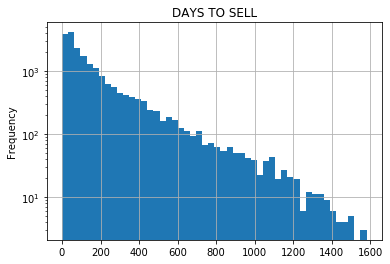

In [80]:
q1 = df['days_listed'].quantile(q=0.01)
q2 = df['days_listed'].quantile(q=0.99)
df['days_listed'].plot(kind='hist',bins=50,title="DAYS TO SELL",grid=True,log=True)
print("The average time to sell an apartment is {:} days".format(df['days_listed'].median()))
print(
    "There are {:} outlier apartments with days listed great than {:} or less than {:}"
    .format(len(df.query('days_listed >= @q2 or days_listed <= @q1 ')),q2,q1)
)

The average time to sell an apartment is 96 days (3+ months), while some happening within a day and others taking more than 4 years.

When the outlying values have been removed, all the graphs take the form of a Poisson distribution, although slightly less with ceiling height because of building code requirements and construction standards- warrants further investigation.

In [82]:
# Slice the non-outlying data
df_good = (
    df.query('27 <= total_area <= 205.44 and 48000 <= last_price <= 770880 and 1 <= bedrooms <= 5 and 2.5 <= ceiling_height <= 3.64 and 4 <= days_listed <= 1085')
)
df_good.describe()

,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,floor,...,park_dist,parks_within_3000,pond_dist,ponds_within_3000,price_per_square_meter,published_day,published_month,published_year,ratio_living,ratio_kitchen
count,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,...,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000
mean,172.077327,117633.782535,2.028242,10.664813,47.260192,57.925005,0.612460,2.683550,11.353254,6.242318,...,468.567725,0.487969,511.513839,0.619973,2000.198259,2.572752,6.582976,2017.228536,0.805113,0.194887
std,196.230548,76671.769500,0.935769,5.405057,21.862464,24.214001,0.970738,0.171571,6.626846,5.022406,...,208.146628,0.745600,177.222801,0.884928,638.118857,1.777970,3.486209,0.949476,0.079607,0.079607
min,4.000000,48000.000000,1.000000,1.800000,7.000000,27.000000,0.000000,2.500000,0.000000,1.000000,...,1.000000,0.000000,13.000000,0.000000,336.842105,0.000000,1.000000,2014.000000,0.212121,0.027778
25%,45.000000,73800.000000,1.000000,7.300000,30.000000,41.000000,0.000000,2.600000,5.000000,3.000000,...,455.000000,0.000000,502.000000,0.000000,1617.248350,1.000000,3.000000,2017.000000,0.762319,0.139344
50%,95.000000,94325.000000,2.000000,9.600000,43.000000,52.100000,0.000000,2.650000,9.000000,5.000000,...,455.000000,0.000000,502.000000,0.000000,1919.753432,3.000000,7.000000,2017.000000,0.825000,0.175000
75%,225.000000,132000.000000,3.000000,12.000000,57.000000,68.700000,1.000000,2.700000,16.000000,9.000000,...,455.000000,1.000000,502.000000,1.000000,2263.037180,4.000000,10.000000,2018.000000,0.860656,0.237681
max,1085.000000,770000.000000,5.000000,117.900000,188.000000,204.000000,5.000000,3.630000,60.000000,33.000000,...,3190.000000,3.000000,1344.000000,3.000000,12808.447009,6.000000,12.000000,2019.000000,0.972222,0.787879


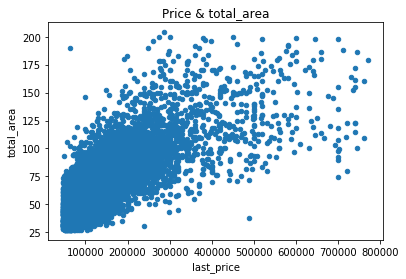

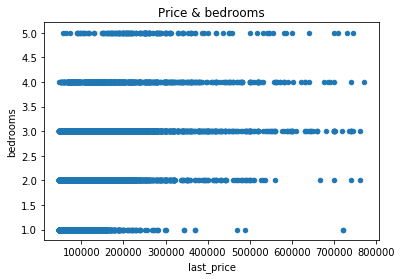

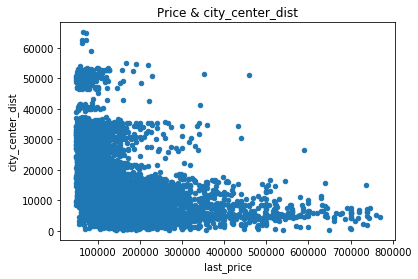

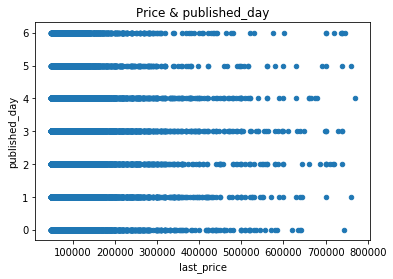

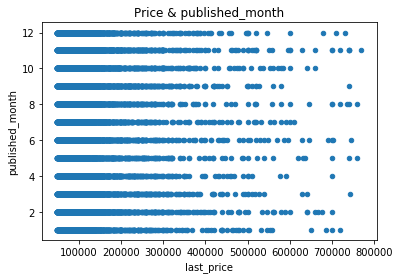

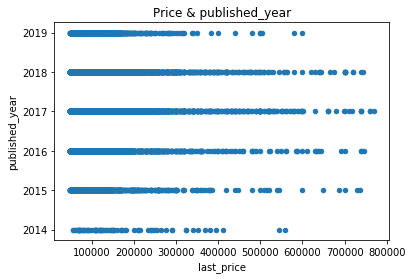

In [84]:
df_columns = ['total_area','bedrooms','city_center_dist','published_day','published_month','published_year']
for column in df_columns:
    df_good.plot(x='last_price', y=column, kind='scatter',title='Price & '+column)

In [85]:
for column in df_columns:
    print("The correlation value of price and {:} is: {:.2}".format(column,df_good['last_price'].corr(df_good[column])))

The correlation value of price and total_area is: 0.77
The correlation value of price and bedrooms is: 0.47
The correlation value of price and city_center_dist is: -0.33
The correlation value of price and published_day is: 0.0034
The correlation value of price and published_month is: 0.0053
The correlation value of price and published_year is: -0.049


By the analysis above: the strongest correlation is total area, then number of bedrooms, and somewhat with proximity to (opposite of distance from) the city center. The publishing day, month or year has no correlation.

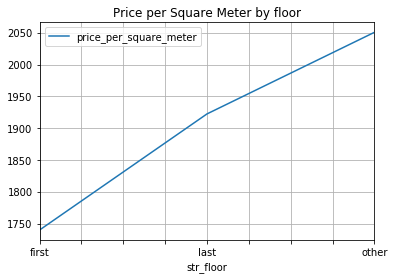

In [86]:
(df_good
    .pivot_table(index='str_floor', values='price_per_square_meter',aggfunc='mean')
    .plot(grid=True,title='Price per Square Meter by floor')
)

Apartments on floors other than the first and second have higher value.

In [87]:
df_locality = (df_good
         .pivot_table(index='locality_name', values='price_per_square_meter',aggfunc={'count','mean'})
         .sort_values('count', ascending=False)
         .head(10)
)
df_locality.columns = ['ads','mean_price']
df_city_dist = (df_good
    .pivot_table(index='locality_name', values='city_center_dist',aggfunc='mean')
)
df_city_dist['city_center_dist'] = df_city_dist['city_center_dist'].round()
df_locality = df_locality.merge(df_city_dist, on='locality_name')
df_locality

,ads,mean_price,city_center_dist
locality_name,,,
saint petersburg,12739,2177.313351,11897.0
murino village,464,1698.838000,21888.0
shushary village,381,1553.882538,24179.0
kolpino,292,1496.366720,32095.0
pushkin,289,2031.789907,28663.0
pargolovo village,287,1801.627609,19865.0
petergof,165,1671.013080,35309.0


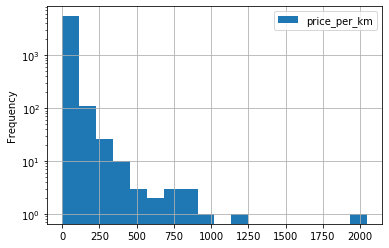

In [104]:
df_st_petersburg = df_good.query('locality_name == "saint petersburg"')
df_st_petersburg = df_st_petersburg.round({'city_center_dist':0})
df_st_petersburg['price_per_km'] = df_st_petersburg['last_price'] / df_st_petersburg['city_center_dist']
(df_st_petersburg
    .pivot_table(index='city_center_dist',values='price_per_km',aggfunc='mean')
    .plot(kind='hist',grid=True,log=True,bins=18)
)

The city border looks to be roughly between 250-400 m as indicated by the spike on the left of the graph.

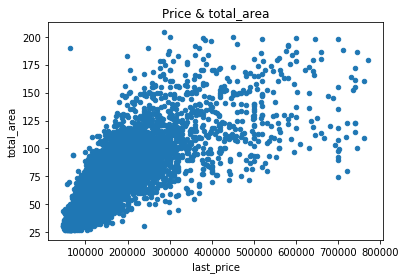

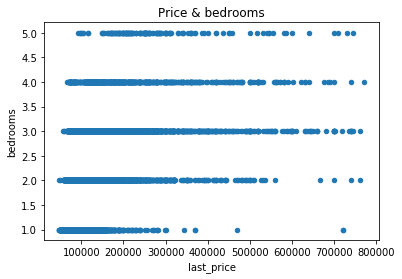

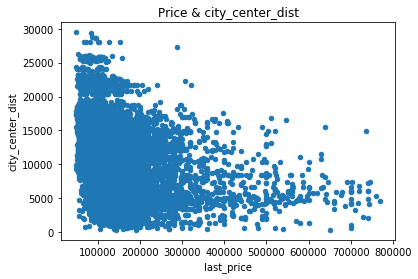

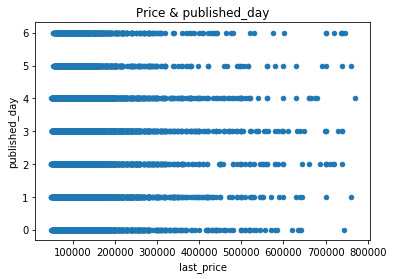

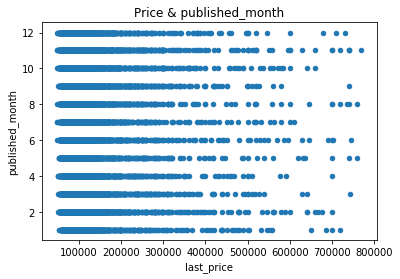

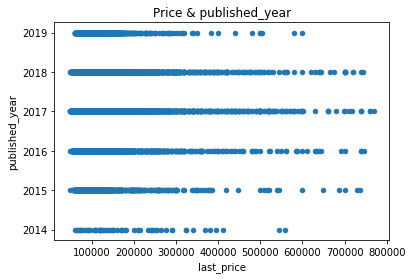

In [105]:
df_city_center = (df_good
    .query('locality_name == "saint petersburg"')                 
)

for column in df_columns:
    df_city_center.plot(x='last_price', y=column, kind='scatter',title='Price & '+column)

In [106]:
for column in df_columns:
    print("The correlation value of price and {:} in Saint Petersburg: {:.2}".format(column,df_city_center['last_price'].corr(df_city_center[column])))

The correlation value of price and total_area in Saint Petersburg: 0.81
The correlation value of price and bedrooms in Saint Petersburg: 0.5
The correlation value of price and city_center_dist in Saint Petersburg: -0.4
The correlation value of price and published_day in Saint Petersburg: 0.006
The correlation value of price and published_month in Saint Petersburg: 0.00088
The correlation value of price and published_year in Saint Petersburg: -0.051


Relative to the overall data, the data in the Saint Petersberg has stronger correlations which makes sense because there is higher prices and demand within the city center.

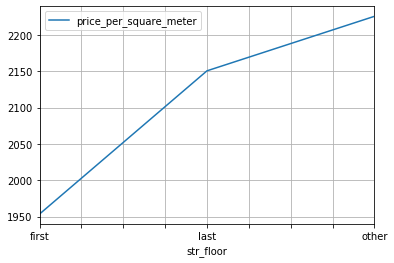

In [228]:
(df_city_center
    .pivot_table(index='str_floor', values='price_per_square_meter',aggfunc='mean')
    .plot(grid=True)
)

In Saint Petersberg the top floors are valued higher relative to overall, likely for the city views/penthouse apartments.

### Conclusion

There were many missing values, some could be addressed by approximating based on existing data and medians while others would too greatly effect the distribution and analysis so needed to be ignored. The city_center_dist could be filled with 0's to indicate that the apartment is inside the city center but it resulted in an extra spike in the distribution. Another example was the days_listed which could mean that the ad wasn't even listed for a full day but is uncertain. The amount of missing values requires further investigation from the data source.

The few outliers were excluded by only slicing data within the 1%-99% IQR of each relevant value. The remaining slice was still large enough to see some clear correlations.

The best indicator of an apartment's value is the total area of the apartment, followed by the number of bedrooms, then it's proximity to the city center. This makes sense when evaluating an apartment having space is a comfort and needed for occupant's belongings, bedrooms are important because we spend a good portion of our lives sleeping and proximity to the city center is important for social and work reasons. City centers contain the greatest concentration of entertainment, restaurants, and jobs. People hate commuting!